### Part 01. Load packages and libs

In [1]:
import warnings
import os
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

warnings.filterwarnings("ignore")

### Part 02. Writing a custom dataset for Blood Cell Segmemtation dataset, write data loader to load data for train model

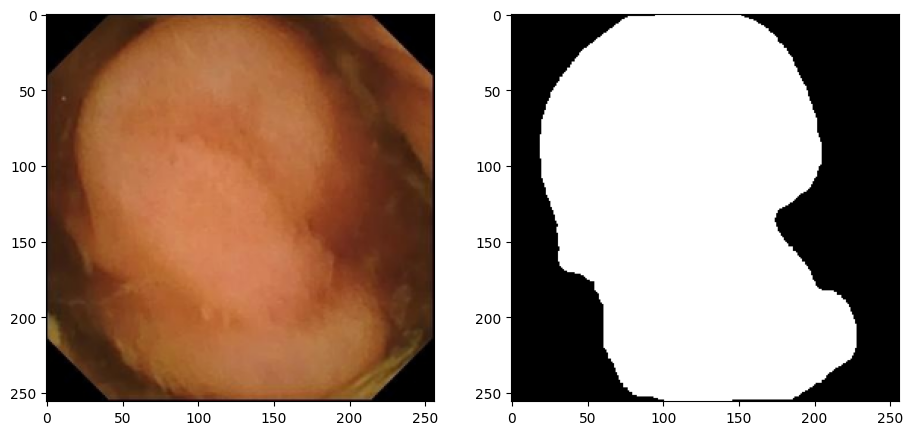

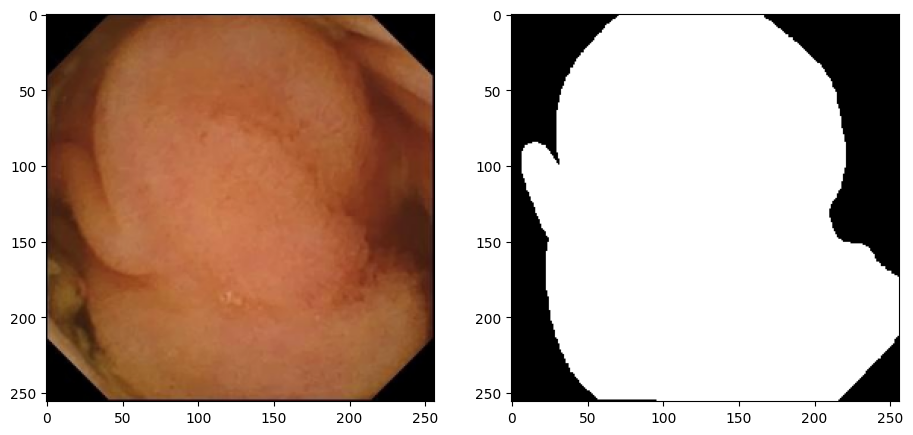

In [2]:
TRAIN_IMG_DIR = "datasets/kvasir_capsule/train/images"
TRAIN_MASK_DIR = "datasets/kvasir_capsule/train/masks"
VAL_IMG_DIR = "datasets/kvasir_capsule/test/images"
VAL_MASK_DIR = "datasets/kvasir_capsule/test/masks"


class BloodCellDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None) -> None:
        super(BloodCellDataset, self).__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(
            self.mask_dir, self.images[index])

        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"),
                        dtype=np.float32)
        # mask[mask == 255.0] = 1.0
        mask = np.where(mask > 155.0, 1.0, 0.0)

        if self.transform is not None:
            augemantations = self.transform(image=image, mask=mask)
            image = augemantations['image']
            mask = augemantations['mask']
        return image, mask

def get_data_loaders(
        train_dir, train_mask_dir, val_dir, val_maskdir, batch_size,
        train_transform, val_transform):

    train_ds = BloodCellDataset(
        image_dir=train_dir, mask_dir=train_mask_dir,
        transform=train_transform)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
    )

    val_ds = BloodCellDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

train_transform = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

BATCH_SIZE = 2

train_loader, val_loader = get_data_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VAL_IMG_DIR,
    VAL_MASK_DIR,
    BATCH_SIZE,
    train_transform,
    val_transforms
)

def show_transformed(data_loader):
    batch = next(iter(data_loader))
    images, labels = batch

    for img, mask in zip(images, labels):
        plt.figure(figsize=(11, 11))

        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(img, (1, 2, 0)))

        plt.subplot(1, 2, 2)
        # plt.imshow(mask.reshape(mask.shape[0], mask.shape[1], 1))
        plt.imshow(mask, cmap="gray")

show_transformed(val_loader)

### Part 03. Implement the deeplabv3+ model from scratch with pytorch

In [3]:
class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNetPlusPlus, self).__init__()

        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = self.conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = self.decoder4(torch.cat([dec4, enc4], dim=1))

        dec3 = self.upconv3(dec4)
        dec3 = self.decoder3(torch.cat([dec3, enc3], dim=1))

        dec2 = self.upconv2(dec3)
        dec2 = self.decoder2(torch.cat([dec2, enc2], dim=1))

        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat([dec1, enc1], dim=1))

        return self.final_conv(dec1)

### Part 04. Define the Dice loss func and IoU func because we are implementing from scratch

In [4]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.bce_losss = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets, smooth=1):
        BCE = self.bce_losss(inputs, targets)
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(
            inputs.sum() + targets.sum() + smooth)
        Dice_BCE = BCE + dice_loss
        return Dice_BCE


class IOU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IOU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)
        return IoU

### Part 05. Define some hyper-parameters and vars to prepare for train the model

In [5]:
# model = Deeplabv3Plus(num_classes=1).to(DEVICE)
model = UNetPlusPlus(in_channels=3, out_channels=1).to(DEVICE)

loss_fn = DiceBCELoss()

iou_fn = IOU()
scaler = torch.cuda.amp.GradScaler()
LEARNING_RATE = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_iou = []
train_loss = []
train_dice = []

def save_checkpoint(state, filename="model.pth.tar"):
    print("=> Saving checkpoint")
    # torch.save(state, filename)

In [6]:
model

UNetPlusPlus(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, 

In [7]:
print(model)

UNetPlusPlus(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, 

### Part 06. Start training model trained

In [8]:
start_time = time.time()

# let's train it just for 2 epochs
NUM_EPOCHS = 32

for epoch in range(NUM_EPOCHS):
    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}")

    iterations = 0
    iter_loss = 0.0
    iter_iou = 0.0

    batch_loop = tqdm(train_loader)
    for batch_idx, (data, targets) in enumerate(batch_loop):

        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        with torch.autocast(device_type=DEVICE, dtype=torch.bfloat16):
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            iou = iou_fn(predictions, targets)

            iter_loss += loss.item()
            iter_iou += iou.item()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        iterations += 1
        batch_loop.set_postfix(diceloss=loss.item(), iou=iou.item())

    train_loss.append(iter_loss / iterations)
    train_iou.append(iter_iou / iterations)
    # print(
    #     f"Epoch: {epoch+1}/{NUM_EPOCHS}, Training loss: {round(train_loss[-1] , 3)}")
    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}, IoU score: {iter_iou / iterations}")

    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict()
    }
    # save_checkpoint(checkpoint)

    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    # print(
    #     f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    # )
    print(
        f"Epoch: {epoch+1}/{NUM_EPOCHS}, Total num_correct/num_pixels: {num_correct}/{num_pixels} => {num_correct/num_pixels}"
    )
    print(
        f"Epoch: {epoch+1}/{NUM_EPOCHS}, Dice score: {dice_score / len(val_loader)}")
    train_dice.append(dice_score / len(val_loader))
    model.train()

print("done ..")

end_time = time.time()
training_time = end_time - start_time
print(
    f"The training time of the UNET++ model is: {training_time:.2f} seconds")

Epoch: 1/32


100%|██████████| 22/22 [00:11<00:00,  1.85it/s, diceloss=0.431, iou=0.692]


Epoch: 1/32, IoU score: 0.5643444765697826
Epoch: 1/32, Total num_correct/num_pixels: 624491/720896 => 0.8662706017494202
Epoch: 1/32, Dice score: 0.8891014317234709
Epoch: 2/32


100%|██████████| 22/22 [00:11<00:00,  1.89it/s, diceloss=0.383, iou=0.738]


Epoch: 2/32, IoU score: 0.6920676664872603
Epoch: 2/32, Total num_correct/num_pixels: 652967/720896 => 0.9057714343070984
Epoch: 2/32, Dice score: 0.9181060468989146
Epoch: 3/32


100%|██████████| 22/22 [00:11<00:00,  1.88it/s, diceloss=0.375, iou=0.747]


Epoch: 3/32, IoU score: 0.7200088148767297
Epoch: 3/32, Total num_correct/num_pixels: 682229/720896 => 0.9463626146316528
Epoch: 3/32, Dice score: 0.9529971098384037
Epoch: 4/32


100%|██████████| 22/22 [00:11<00:00,  1.87it/s, diceloss=0.363, iou=0.727]


Epoch: 4/32, IoU score: 0.7336883382363752
Epoch: 4/32, Total num_correct/num_pixels: 669260/720896 => 0.9283725023269653
Epoch: 4/32, Dice score: 0.9383761630851659
Epoch: 5/32


100%|██████████| 22/22 [00:11<00:00,  1.87it/s, diceloss=0.295, iou=0.779]


Epoch: 5/32, IoU score: 0.7516932406208732
Epoch: 5/32, Total num_correct/num_pixels: 683113/720896 => 0.9475888609886169
Epoch: 5/32, Dice score: 0.9565110364861948
Epoch: 6/32


100%|██████████| 22/22 [00:11<00:00,  1.84it/s, diceloss=0.292, iou=0.783]


Epoch: 6/32, IoU score: 0.7624057721007954
Epoch: 6/32, Total num_correct/num_pixels: 676160/720896 => 0.9379439353942871
Epoch: 6/32, Dice score: 0.9518689816503709
Epoch: 7/32


100%|██████████| 22/22 [00:12<00:00,  1.78it/s, diceloss=0.341, iou=0.773]


Epoch: 7/32, IoU score: 0.7657572979276831
Epoch: 7/32, Total num_correct/num_pixels: 680801/720896 => 0.9443817138671875
Epoch: 7/32, Dice score: 0.9542695940792392
Epoch: 8/32


100%|██████████| 22/22 [00:12<00:00,  1.76it/s, diceloss=0.387, iou=0.749]


Epoch: 8/32, IoU score: 0.7787222591313449
Epoch: 8/32, Total num_correct/num_pixels: 669036/720896 => 0.9280617833137512
Epoch: 8/32, Dice score: 0.9446424577631263
Epoch: 9/32


100%|██████████| 22/22 [00:12<00:00,  1.72it/s, diceloss=0.456, iou=0.721]


Epoch: 9/32, IoU score: 0.784612931988456
Epoch: 9/32, Total num_correct/num_pixels: 681610/720896 => 0.9455039501190186
Epoch: 9/32, Dice score: 0.9549173339693496
Epoch: 10/32


100%|██████████| 22/22 [00:12<00:00,  1.70it/s, diceloss=0.25, iou=0.82]  


Epoch: 10/32, IoU score: 0.7848542766137556
Epoch: 10/32, Total num_correct/num_pixels: 681128/720896 => 0.944835364818573
Epoch: 10/32, Dice score: 0.956231289448958
Epoch: 11/32


100%|██████████| 22/22 [00:13<00:00,  1.69it/s, diceloss=0.359, iou=0.786]


Epoch: 11/32, IoU score: 0.7996238930658861
Epoch: 11/32, Total num_correct/num_pixels: 671406/720896 => 0.9313493371009827
Epoch: 11/32, Dice score: 0.94484396227923
Epoch: 12/32


100%|██████████| 22/22 [00:13<00:00,  1.67it/s, diceloss=0.258, iou=0.811]


Epoch: 12/32, IoU score: 0.8031299412250519
Epoch: 12/32, Total num_correct/num_pixels: 686160/720896 => 0.9518155455589294
Epoch: 12/32, Dice score: 0.9595934986342616
Epoch: 13/32


100%|██████████| 22/22 [00:13<00:00,  1.67it/s, diceloss=0.235, iou=0.829]


Epoch: 13/32, IoU score: 0.8026799017732794
Epoch: 13/32, Total num_correct/num_pixels: 656350/720896 => 0.9104642271995544
Epoch: 13/32, Dice score: 0.9284551105228666
Epoch: 14/32


100%|██████████| 22/22 [00:13<00:00,  1.67it/s, diceloss=0.236, iou=0.811]


Epoch: 14/32, IoU score: 0.8106978562745181
Epoch: 14/32, Total num_correct/num_pixels: 686580/720896 => 0.9523981809616089
Epoch: 14/32, Dice score: 0.9611852642641949
Epoch: 15/32


100%|██████████| 22/22 [00:13<00:00,  1.65it/s, diceloss=0.161, iou=0.87] 


Epoch: 15/32, IoU score: 0.8237108913334933
Epoch: 15/32, Total num_correct/num_pixels: 670237/720896 => 0.9297277331352234
Epoch: 15/32, Dice score: 0.947186769179458
Epoch: 16/32


100%|██████████| 22/22 [00:13<00:00,  1.63it/s, diceloss=0.294, iou=0.807]


Epoch: 16/32, IoU score: 0.8370671949603341
Epoch: 16/32, Total num_correct/num_pixels: 661351/720896 => 0.9174014329910278
Epoch: 16/32, Dice score: 0.9362797730056861
Epoch: 17/32


100%|██████████| 22/22 [00:13<00:00,  1.65it/s, diceloss=0.236, iou=0.839]


Epoch: 17/32, IoU score: 0.8352880667556416
Epoch: 17/32, Total num_correct/num_pixels: 662042/720896 => 0.9183599352836609
Epoch: 17/32, Dice score: 0.9370799782936272
Epoch: 18/32


100%|██████████| 22/22 [00:13<00:00,  1.65it/s, diceloss=0.393, iou=0.763]


Epoch: 18/32, IoU score: 0.8438465866175565
Epoch: 18/32, Total num_correct/num_pixels: 673611/720896 => 0.9344080686569214
Epoch: 18/32, Dice score: 0.9487655787744618
Epoch: 19/32


100%|██████████| 22/22 [00:13<00:00,  1.63it/s, diceloss=0.183, iou=0.868]


Epoch: 19/32, IoU score: 0.8371492759747938
Epoch: 19/32, Total num_correct/num_pixels: 664665/720896 => 0.9219985008239746
Epoch: 19/32, Dice score: 0.9399128199178997
Epoch: 20/32


100%|██████████| 22/22 [00:13<00:00,  1.63it/s, diceloss=0.266, iou=0.829]


Epoch: 20/32, IoU score: 0.8517421538179571
Epoch: 20/32, Total num_correct/num_pixels: 680692/720896 => 0.9442305564880371
Epoch: 20/32, Dice score: 0.9546864098324012
Epoch: 21/32


100%|██████████| 22/22 [00:13<00:00,  1.64it/s, diceloss=0.254, iou=0.848]


Epoch: 21/32, IoU score: 0.8557716906070709
Epoch: 21/32, Total num_correct/num_pixels: 680273/720896 => 0.9436492919921875
Epoch: 21/32, Dice score: 0.9557927644020079
Epoch: 22/32


100%|██████████| 22/22 [00:13<00:00,  1.62it/s, diceloss=0.366, iou=0.796]


Epoch: 22/32, IoU score: 0.8598879927938635
Epoch: 22/32, Total num_correct/num_pixels: 685510/720896 => 0.9509139060974121
Epoch: 22/32, Dice score: 0.9606867815823297
Epoch: 23/32


100%|██████████| 22/22 [00:13<00:00,  1.63it/s, diceloss=0.197, iou=0.855]


Epoch: 23/32, IoU score: 0.8522757508537986
Epoch: 23/32, Total num_correct/num_pixels: 670954/720896 => 0.9307223558425903
Epoch: 23/32, Dice score: 0.9448523951399516
Epoch: 24/32


100%|██████████| 22/22 [00:13<00:00,  1.62it/s, diceloss=0.147, iou=0.88] 


Epoch: 24/32, IoU score: 0.8586645045063712
Epoch: 24/32, Total num_correct/num_pixels: 673325/720896 => 0.9340113401412964
Epoch: 24/32, Dice score: 0.9486622511933311
Epoch: 25/32


100%|██████████| 22/22 [00:13<00:00,  1.63it/s, diceloss=0.208, iou=0.86] 


Epoch: 25/32, IoU score: 0.8648870451883837
Epoch: 25/32, Total num_correct/num_pixels: 657667/720896 => 0.9122911095619202
Epoch: 25/32, Dice score: 0.9312703467860812
Epoch: 26/32


100%|██████████| 22/22 [00:13<00:00,  1.63it/s, diceloss=0.158, iou=0.888]


Epoch: 26/32, IoU score: 0.867703529921445
Epoch: 26/32, Total num_correct/num_pixels: 658150/720896 => 0.9129611253738403
Epoch: 26/32, Dice score: 0.9334319428256805
Epoch: 27/32


100%|██████████| 22/22 [00:13<00:00,  1.63it/s, diceloss=0.15, iou=0.892] 


Epoch: 27/32, IoU score: 0.8776244168931787
Epoch: 27/32, Total num_correct/num_pixels: 679256/720896 => 0.9422385692596436
Epoch: 27/32, Dice score: 0.9530800302962497
Epoch: 28/32


100%|██████████| 22/22 [00:13<00:00,  1.63it/s, diceloss=0.191, iou=0.871]


Epoch: 28/32, IoU score: 0.8765911622480913
Epoch: 28/32, Total num_correct/num_pixels: 673813/720896 => 0.9346882700920105
Epoch: 28/32, Dice score: 0.9484364458750809
Epoch: 29/32


100%|██████████| 22/22 [00:13<00:00,  1.63it/s, diceloss=0.184, iou=0.872]


Epoch: 29/32, IoU score: 0.8723417791453275
Epoch: 29/32, Total num_correct/num_pixels: 693837/720896 => 0.9624648094177246
Epoch: 29/32, Dice score: 0.9691409638489797
Epoch: 30/32


100%|██████████| 22/22 [00:13<00:00,  1.63it/s, diceloss=0.12, iou=0.91]  


Epoch: 30/32, IoU score: 0.8838510323654521
Epoch: 30/32, Total num_correct/num_pixels: 670941/720896 => 0.9307042956352234
Epoch: 30/32, Dice score: 0.9463877052380819
Epoch: 31/32


100%|██████████| 22/22 [00:13<00:00,  1.63it/s, diceloss=0.161, iou=0.888]


Epoch: 31/32, IoU score: 0.8789301026951183
Epoch: 31/32, Total num_correct/num_pixels: 657093/720896 => 0.9114949107170105
Epoch: 31/32, Dice score: 0.930494698466582
Epoch: 32/32


100%|██████████| 22/22 [00:13<00:00,  1.62it/s, diceloss=0.201, iou=0.874]


Epoch: 32/32, IoU score: 0.8750712763179432
Epoch: 32/32, Total num_correct/num_pixels: 670610/720896 => 0.9302451610565186
Epoch: 32/32, Dice score: 0.9459349845259722
done ..
The training time of the UNET++ model is: 429.37 seconds


### Part 07. Visualize the training process and test the model trained

In [9]:
print(train_loss)

[0.7025644819844853, 0.46466337415305053, 0.41794090514833276, 0.40279239551587537, 0.3630544285882603, 0.34790191731669684, 0.3426050144163045, 0.32259656150232663, 0.3138276440176097, 0.31472718851132825, 0.2897272225130688, 0.29217761145396665, 0.2869160825555975, 0.2819455035708167, 0.2520941306244243, 0.22918025201017206, 0.23792088234966452, 0.22816536101427945, 0.23632072589614175, 0.21688478778709064, 0.20629029314626346, 0.20226336406035858, 0.21740406142039734, 0.21053833243521777, 0.1962714527140964, 0.19534691694107922, 0.17165948856960644, 0.18326576325026425, 0.18432908471335063, 0.17369533465667206, 0.18513288179581816, 0.18731462176550517]


In [10]:
print(train_iou)

[0.5643444765697826, 0.6920676664872603, 0.7200088148767297, 0.7336883382363752, 0.7516932406208732, 0.7624057721007954, 0.7657572979276831, 0.7787222591313449, 0.784612931988456, 0.7848542766137556, 0.7996238930658861, 0.8031299412250519, 0.8026799017732794, 0.8106978562745181, 0.8237108913334933, 0.8370671949603341, 0.8352880667556416, 0.8438465866175565, 0.8371492759747938, 0.8517421538179571, 0.8557716906070709, 0.8598879927938635, 0.8522757508537986, 0.8586645045063712, 0.8648870451883837, 0.867703529921445, 0.8776244168931787, 0.8765911622480913, 0.8723417791453275, 0.8838510323654521, 0.8789301026951183, 0.8750712763179432]


In [11]:
print(train_dice)

[tensor(0.8891, device='cuda:0', dtype=torch.float64), tensor(0.9181, device='cuda:0', dtype=torch.float64), tensor(0.9530, device='cuda:0', dtype=torch.float64), tensor(0.9384, device='cuda:0', dtype=torch.float64), tensor(0.9565, device='cuda:0', dtype=torch.float64), tensor(0.9519, device='cuda:0', dtype=torch.float64), tensor(0.9543, device='cuda:0', dtype=torch.float64), tensor(0.9446, device='cuda:0', dtype=torch.float64), tensor(0.9549, device='cuda:0', dtype=torch.float64), tensor(0.9562, device='cuda:0', dtype=torch.float64), tensor(0.9448, device='cuda:0', dtype=torch.float64), tensor(0.9596, device='cuda:0', dtype=torch.float64), tensor(0.9285, device='cuda:0', dtype=torch.float64), tensor(0.9612, device='cuda:0', dtype=torch.float64), tensor(0.9472, device='cuda:0', dtype=torch.float64), tensor(0.9363, device='cuda:0', dtype=torch.float64), tensor(0.9371, device='cuda:0', dtype=torch.float64), tensor(0.9488, device='cuda:0', dtype=torch.float64), tensor(0.9399, device='cuda

In [12]:
train_dice = [t.cpu().item() for t in train_dice]

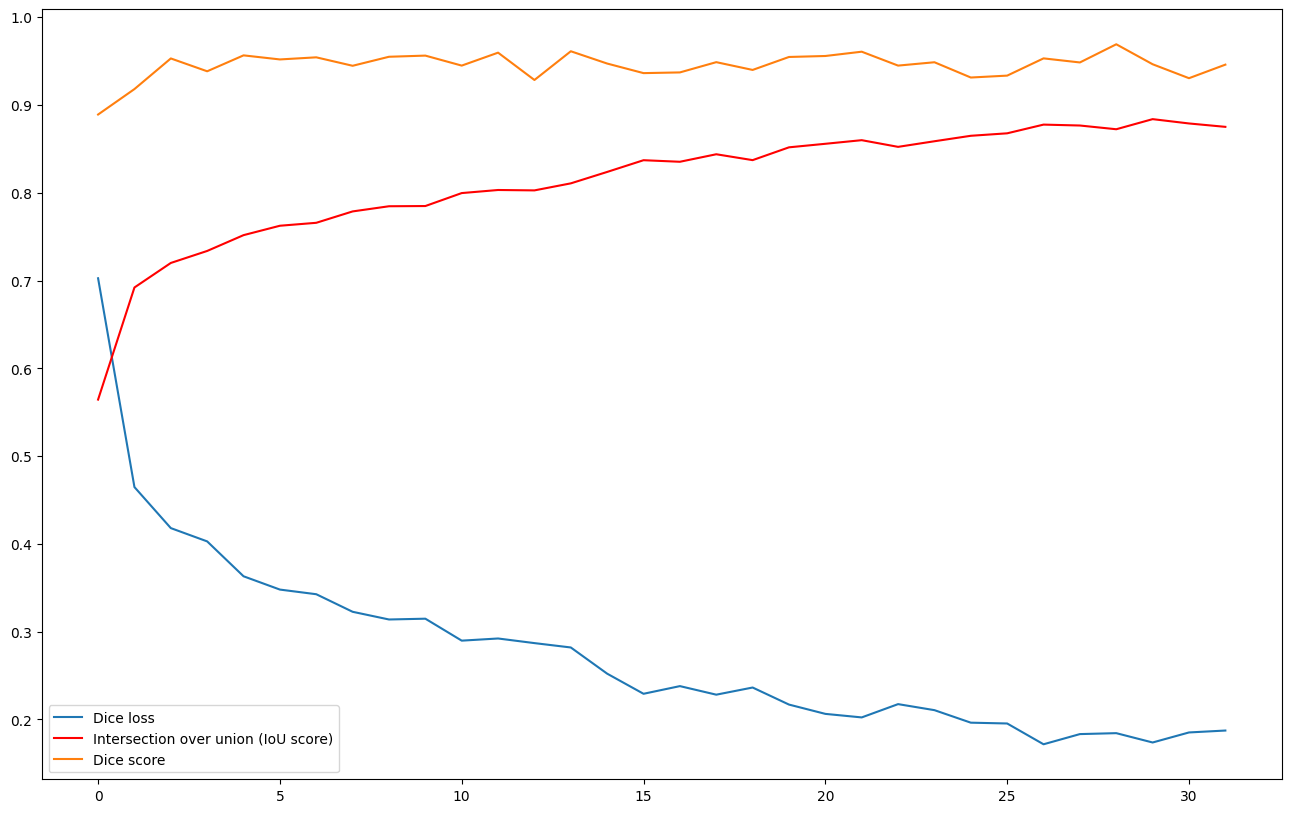

In [13]:
f = plt.figure(figsize=(16, 10))
plt.plot(train_loss, label='Dice loss')
# plt.plot(train_iou, label='Intersection over union (IoU score)')
plt.plot(train_iou, label='Intersection over union (IoU score)', color='red')
plt.plot(train_dice, label='Dice score')
plt.legend()
plt.show()

In [14]:
def test_model(model, val_loader, device):
    model.eval()
    dice_score = 0
    iou_metric = IOU()
    iou_score = 0

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc="Testing"):
            x = x.to(device)
            y = y.to(device).unsqueeze(1)

            preds = torch.sigmoid(model(x))
            preds_binary = (preds > 0.5).float()

            dice_score += (2 * (preds_binary * y).sum()) / (
                (preds_binary + y).sum() + 1e-8
            )
            iou_score += iou_metric(preds_binary, y)

    avg_dice = dice_score / len(val_loader)
    avg_iou = iou_score / len(val_loader)

    print(f"Average Dice Score: {avg_dice:.4f}")
    print(f"Average IoU Score: {avg_iou:.4f}")

    return avg_dice, avg_iou

avg_dice, avg_iou = test_model(model, val_loader, DEVICE)

Testing: 100%|██████████| 6/6 [00:00<00:00, 16.52it/s]

Average Dice Score: 0.9459
Average IoU Score: 0.5241


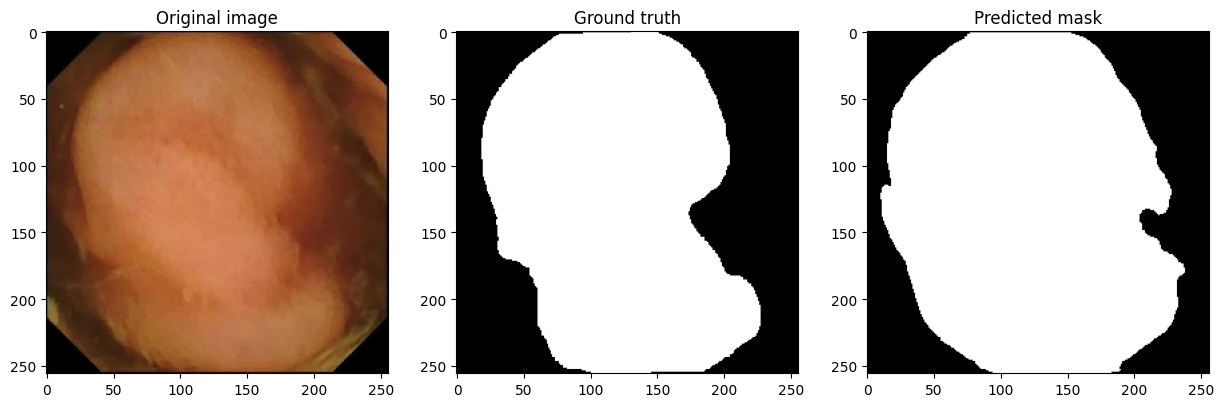

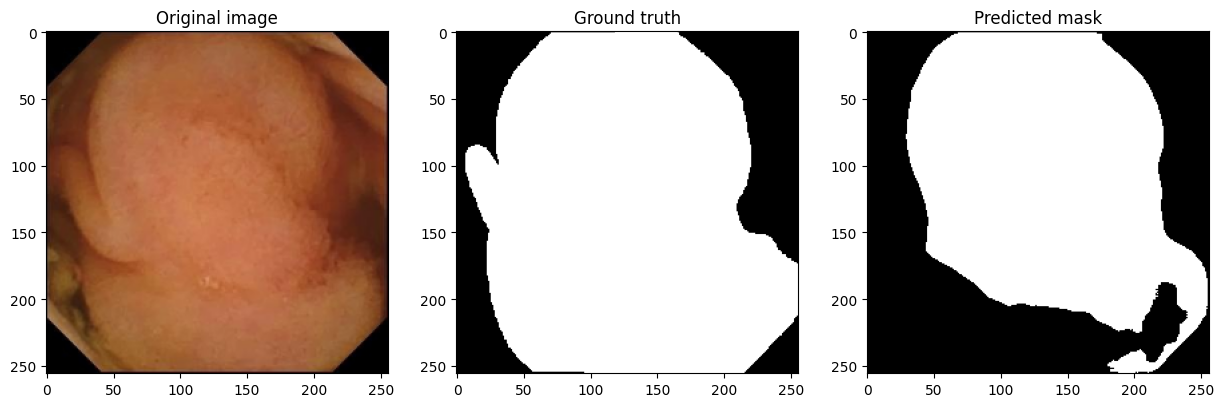

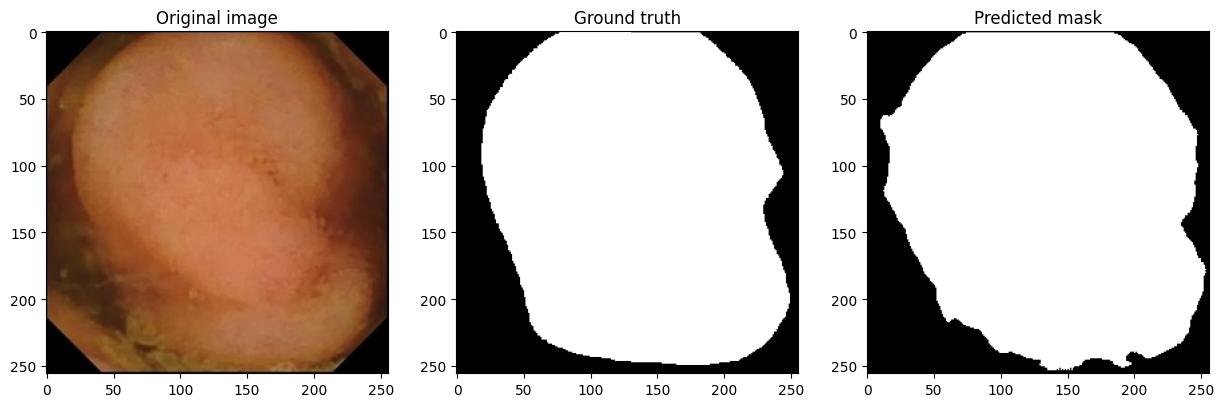

In [15]:
def visualize_predictions(model, val_loader, device, num_samples=3):
    model.eval()
    samples = 0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds_binary = (preds > 0.5).float()

            for i in range(x.size(0)):
                if samples >= num_samples:
                    break

                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.title("Original image")
                plt.imshow(np.transpose(x[i].cpu().numpy(), (1, 2, 0)))

                plt.subplot(1, 3, 2)
                plt.title("Ground truth")
                plt.imshow(y[i].cpu().numpy().squeeze(), cmap="gray")

                plt.subplot(1, 3, 3)
                plt.title("Predicted mask")
                plt.imshow(preds_binary[i].cpu(
                ).numpy().squeeze(), cmap="gray")

                plt.show()
                samples += 1

            if samples >= num_samples:
                break

visualize_predictions(model, val_loader, DEVICE)

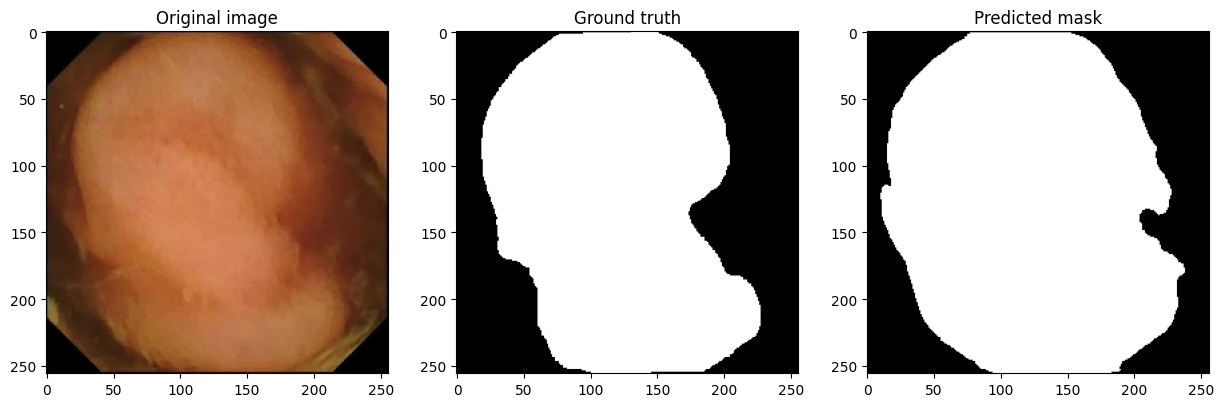

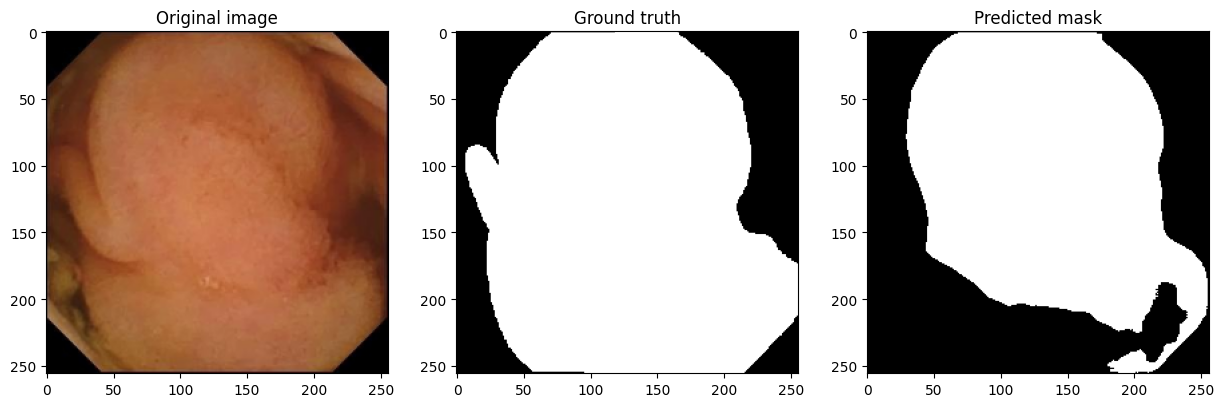

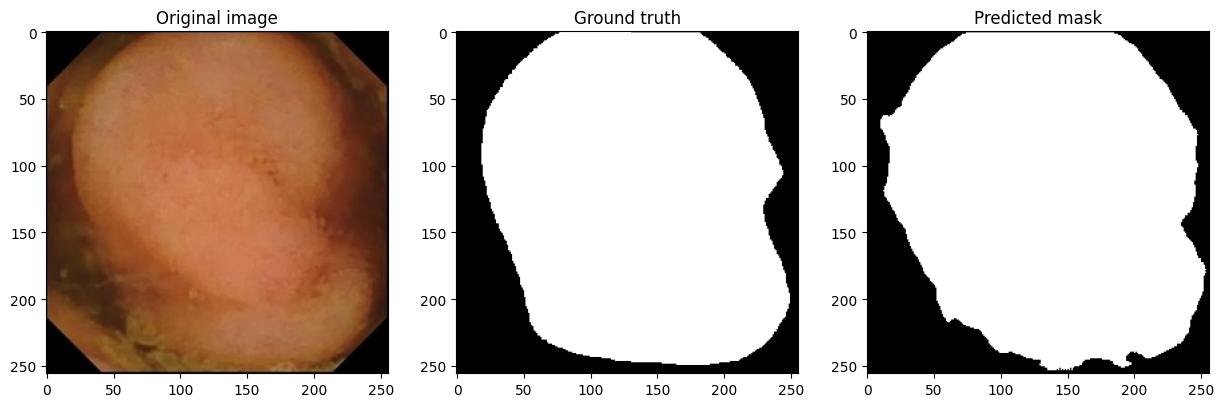

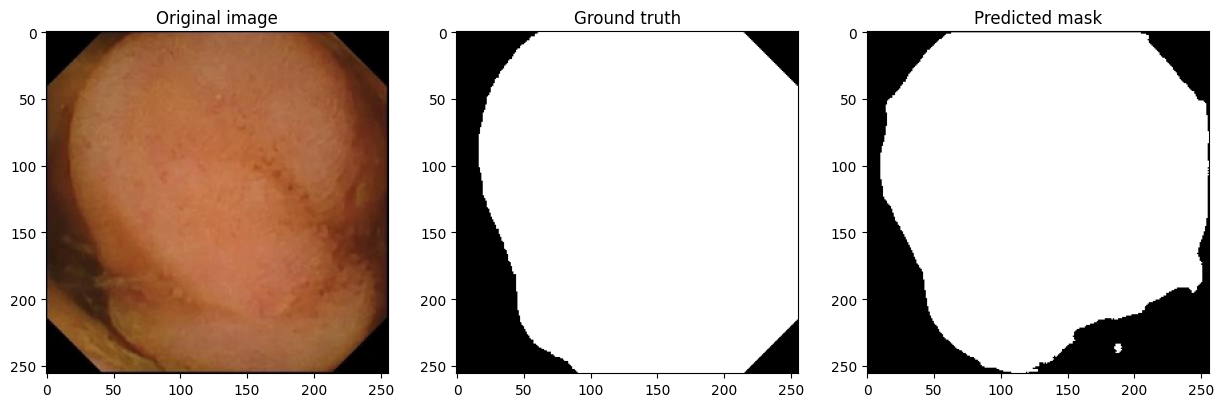

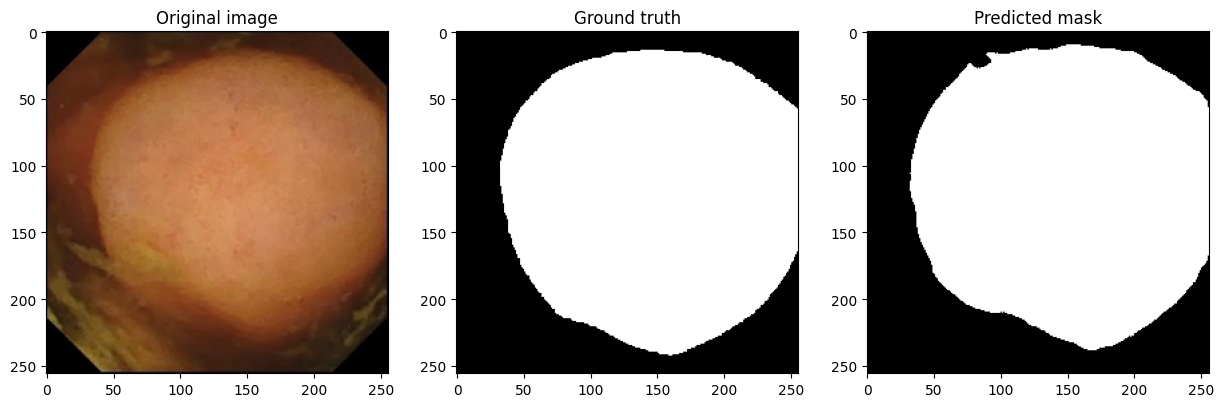

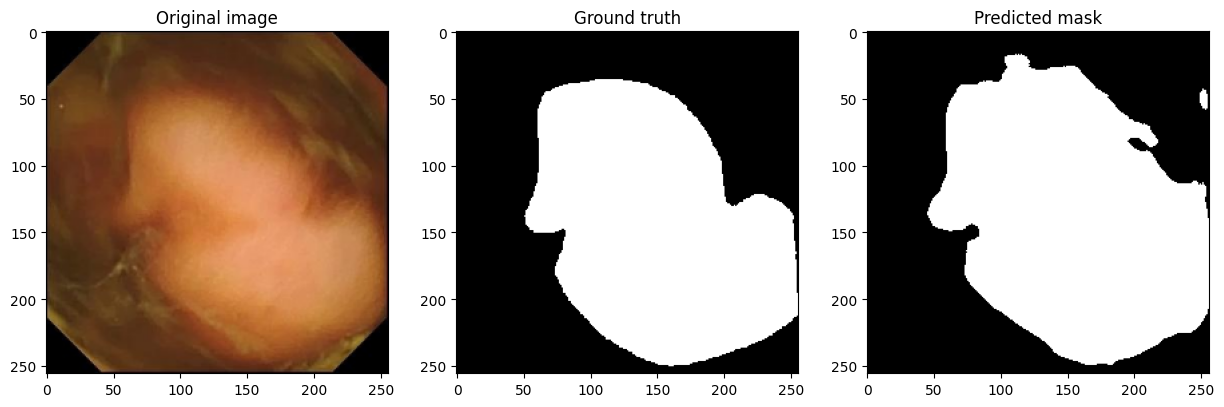

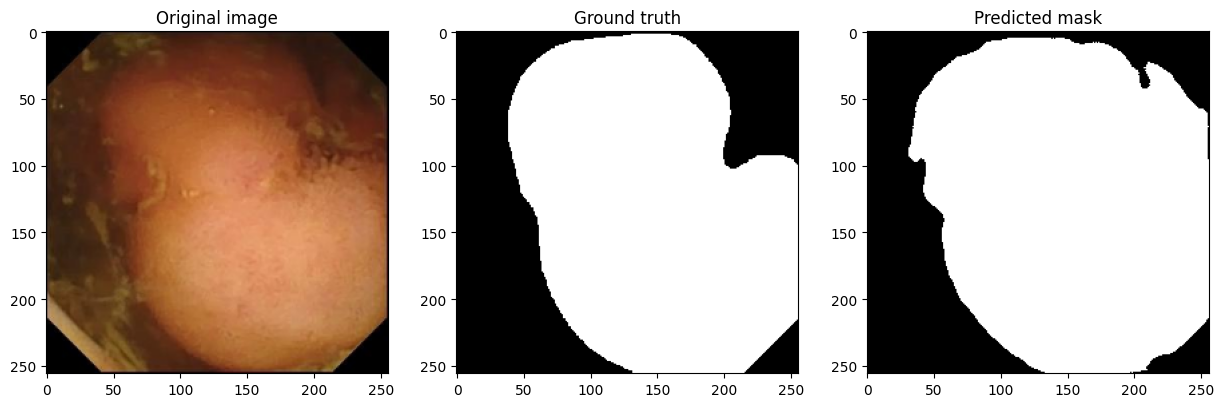

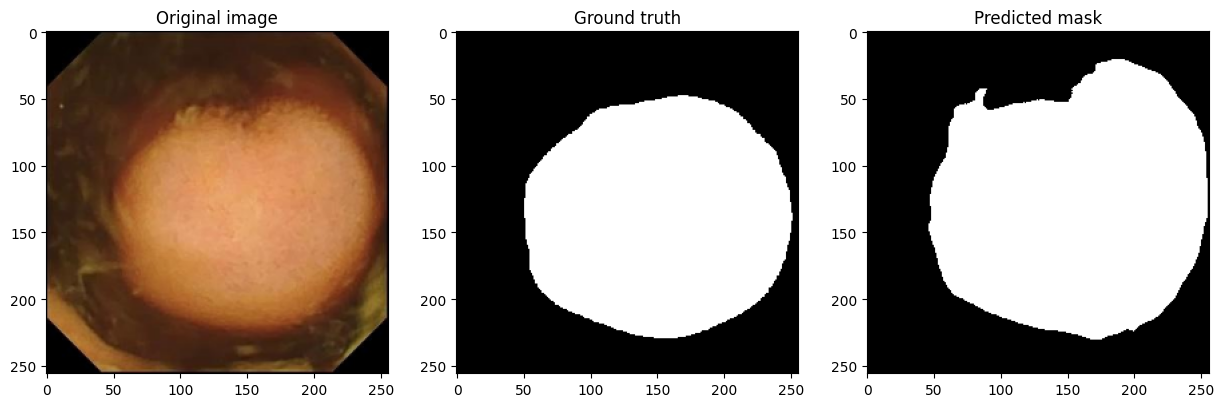

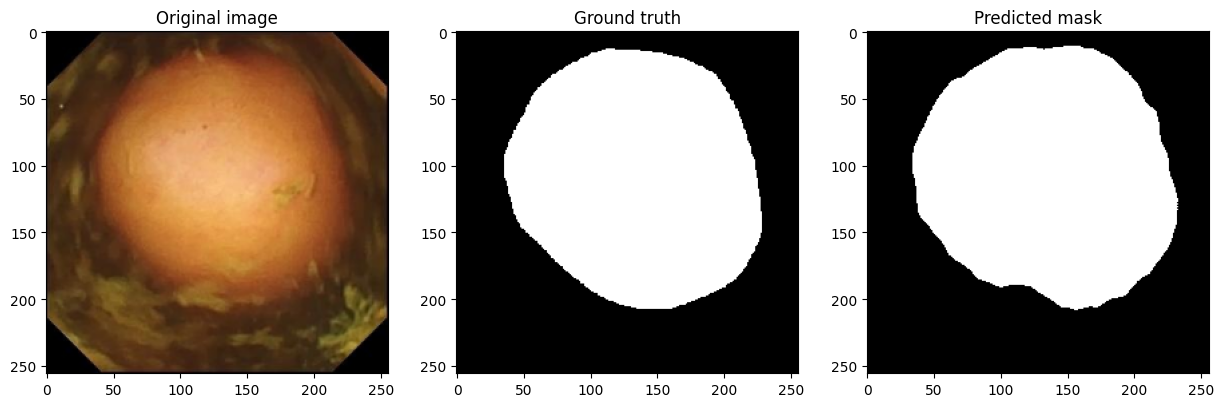

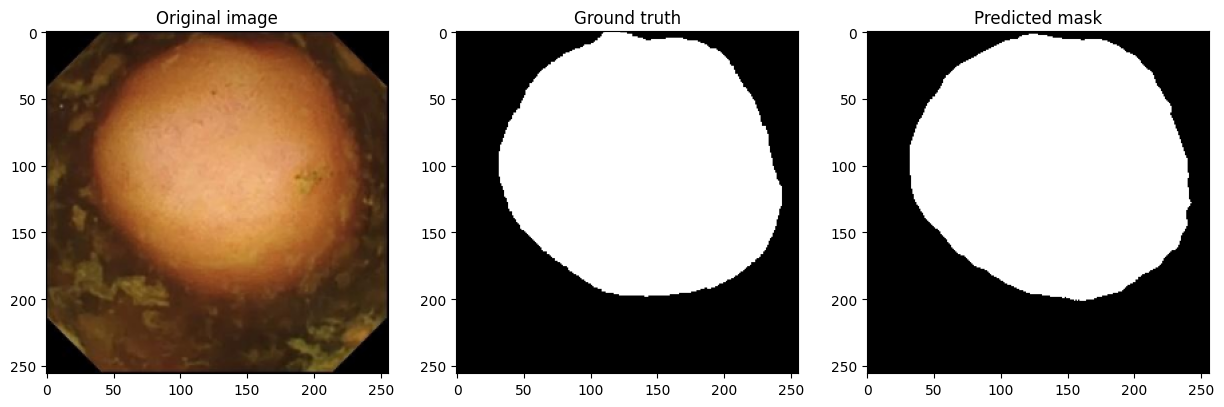

In [16]:
visualize_predictions(model, val_loader, DEVICE, num_samples=10)

In [17]:
# visualize_predictions(model, val_loader, DEVICE, num_samples=100)